In [1]:
import itertools
import pandas as pd
import numpy as np
import heapq
from Bio import Phylo
from ete3 import Tree
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
import io


my_tree=[]

class MinHeap(object):
    def __init__(self, initial=None, key=lambda x:x):
        self.key = key
        if initial:
            self._data = [(key(item), item) for item in initial]
            heapq.heapify(self._data)
        else:
            self._data = []

    def push(self, item):
        heapq.heappush(self._data, (self.key(item), item))

    def pop(self):
        return heapq.heappop(self._data)[1]
    
    def __len__(self):
        return len(self._data)


def seq_dist(S1,S2):
    score = 0
    for S1c,S2c in zip(list(S1),list(S2)):
        if (S1c != S2c):
            score = score + 1

    return score

def seq__pairwise_dist(S1,S2):
    return pairwise2.align.globaldx(S1, S2,matlist.blosum62,score_only=True)



def seq_comb(sequece_list):
    return(itertools.combinations( range(0,len(sequece_list)), 2))



def seq_list_dist(comb,sequece_list):
   
    sequence_dist_list = []

    for cm in comb:
        S1 = sequece_list[cm[0]]
        S2 = sequece_list[cm[1]]

        dist = [cm[0],cm[1],seq__pairwise_dist(S1,S2)]
        sequence_dist_list.append(dist)
    
   
    #print(sequence_dist_list)
    return(sequence_dist_list)


def list_to_matrix(sequece_list, seq_list_dist):
    list_size = len(sequece_list)
    
    ZEROS = np.zeros((list_size,list_size), dtype=np.int)
    
    ## CRIA COLUMN e INDEX LABELS
    labels = []
    for i in range(0,list_size):
        labels.append("S"+str(i))
        
    ## CRIA DF VAZIO COM COLUMN e INDEX LABELS
    df = pd.DataFrame(ZEROS, columns = labels, index=labels)
    
  
    for dist in seq_list_dist:
        # Col,Row
        c = dist[0]
        r = dist[1]
        v = dist[2]
        
        df.iloc[c, r] = v
    #print(df)
    return df
    

def matrix_to_heap(m):
    
    heap = []
    
    for i in m.index:
        for j in m.columns:
            if(m.loc[j,i] != 0):
                heap.append((m.loc[j,i], [j,i]))
    
    hh = MinHeap(heap)
    
    #for x in range(len(hh)):
    #    print(hh.pop())
    hh = MinHeap(heap)

    return hh

def update_matrix(df,R1,R2):
    ## cria nova colum com a soma de r1 e r2
    
    df = df.T + df 
    #print (np.triu(np.ones(df.shape)).astype(np.bool))
    
    comb_name = str(R1)+str(R2)
    comb_value = new_valor_update(df[R1],df[R2])
    
    df[comb_name] = comb_value
    
    #TRANSPOSE
    df = df.T

    comb_value = new_valor_update(df[R1],df[R2])
    df[comb_name] = comb_value
    
    #TRANSPOSE AGAIN TO GO BACK
    df = df.T
    #print(df)
    #REMOVE AS COLUNAS E ROWS
    df = df.drop(columns=[R1, R2])
    df = df.drop([R1, R2])
    
    ## ZERO the R1,R2-R1.R2 valus
    df.loc[comb_name,comb_name] = 0
    
     
    #print(df)
    #df = df.T - df 
    ## select row
    ## create new line with the sum
    ## remove row from dataset
    ##append new line
    ## remove columns
    df = df.where(np.triu(np.ones(df.shape)).astype(np.bool))
    df.fillna(0,inplace=True)
    return df

def new_valor_update(v1,v2):
    return (v2+v1)/2

    
def cria_juncao_folhas(node1,node2,value):
    global my_tree
    my_tree.append([node1,node2,value,node1+node2])
    
    
def main(*seqs):
    
   
    
    sequence_list = list(seqs) #cria lista com os parametros fornecidos
    comb = seq_comb(sequence_list) #cria combinacoes
    sld = seq_list_dist(comb,sequence_list) ## calcula distancia das combinacoes e retorna pronto para criar matrix
    
    #print("1 PASSO")
    nm = list_to_matrix(sequence_list,sld) ## CRIA MATRIX
    print(nm)
    hp = matrix_to_heap(nm)
    v = hp.pop()
    cria_juncao_folhas(v[1][0],v[1][1],v[0])# para a arvore
    
    while nm.shape[0] > 2:
    
        nm = update_matrix(nm,v[1][0],v[1][1])
        print(nm)
        hp = matrix_to_heap(nm)
        v = hp.pop()
        cria_juncao_folhas(v[1][0],v[1][1],v[0])# para a arvore
    
    
    t = []
    
    for c in my_tree:
        print(c)
    for i,mt in enumerate(reversed(my_tree)):
        if i == 0:
            t = Tree(name=mt[3])
            t.add_child(name=mt[0],dist=float(mt[2]))
            t.add_child(name=mt[1],dist=float(mt[2]))
        else:
            print(mt[3])
            x = t.search_nodes(name=mt[3])[0]
            x.add_child(name=mt[0],dist=float(mt[2]))
            x.add_child(name=mt[1],dist=float(mt[2]))

    print(t.write())
    tree = Phylo.read(io.StringIO(t.write()), "newick")
    Phylo.draw(tree,  branch_labels=lambda c: c.name)
    
    #t = Tree(io.StringIO(t.write()))
    #t.show()
    #t.show("heatmap")
   
    





    

    S0    S1    S2    S3    S4    S5
S0   0  51.0  59.0  43.0  45.0  43.0
S1   0   0.0  45.0  37.0  62.0  38.0
S2   0   0.0   0.0  36.0  46.0  41.0
S3   0   0.0   0.0   0.0  35.0  37.0
S4   0   0.0   0.0   0.0   0.0  38.0
S5   0   0.0   0.0   0.0   0.0   0.0
       S0    S1    S2    S5  S3S4
S0    0.0  51.0  59.0  43.0  44.0
S1    0.0   0.0  45.0  38.0  49.5
S2    0.0   0.0   0.0  41.0  41.0
S5    0.0   0.0   0.0   0.0  37.5
S3S4  0.0   0.0   0.0   0.0   0.0
         S0    S1    S2  S5S3S4
S0      0.0  51.0  59.0   43.50
S1      0.0   0.0  45.0   43.75
S2      0.0   0.0   0.0   41.00
S5S3S4  0.0   0.0   0.0    0.00
           S0    S1  S2S5S3S4
S0        0.0  51.0    51.250
S1        0.0   0.0    44.375
S2S5S3S4  0.0   0.0     0.000
             S0  S1S2S5S3S4
S0          0.0      51.125
S1S2S5S3S4  0.0       0.000
['S3', 'S4', 35.0, 'S3S4']
['S5', 'S3S4', 37.5, 'S5S3S4']
['S2', 'S5S3S4', 41.0, 'S2S5S3S4']
['S1', 'S2S5S3S4', 44.375, 'S1S2S5S3S4']
['S0', 'S1S2S5S3S4', 51.125, 'S0S1S2S5S

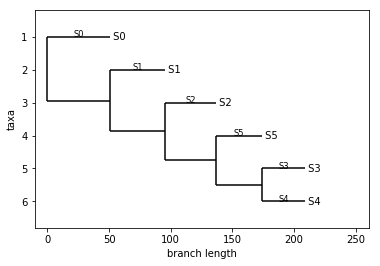

AttributeError: 'TreeNode' object has no attribute 'arraytable'

In [20]:
A = "ATCGTGGTACTG"
B = "CCGGAGAACTAG"
C = "AACGTGCTACTG"
D = "ATGGTGAAAGTG"
E = "CCGGAAAACTTG"
F = "TGGCCCTGTATC"









main(A,B,C,D,E,F)


In [96]:







#t = dendropy.Tree.get_from_string("(A:0.1,B:0.2,(C:0.3,D:0.4):0.5);", "newick")
#t.print_plot()


#tree = Phylo.read("simple.dnd", "newick")

#Phylo.draw(tree)


# (A:0.1,B:0.2, (C:0.3,D:0.4)E:0.5)F;

#[['S0', 'S2', 2], 
#['S1', 'S4', 2.0], 
#['S1,S4', 'S0,S2', 2.25], 
#['S3', 'S1,S4,S0,S2', 1.5], 
#['S3,S1,S4,S0,S2', 'S5', 10.375]]




#tn = Tree(dist=None, support=None, name=None)



#s = ""

#def sconcat_newick(j,ps):
#    global s
    
    #print("buscar, ", j, " em ", s )
#    if s.find(j) == -1 :
        #print("nao achou ", j)
#        s = s + ps
        #print("novo s -> ", s)
#    else:
#        s = s + ps
        #print("achou")
        #print("novo s -> ", s)
        






#['S3S1S4S0S2', 'S5', 10.375, 'S3S1S4S0S2S5', '(S3S1S4S0S2:10.375,S5:10.375)S3S1S4S0S2S5:10.375;']

S3S1S4S0S2 = t.add_child(name="S3S1S4S0S2")
S5 = t.add_child(name="S5")

#['S3', 'S1S4S0S2', 1.5, 'S3S1S4S0S2', '(S3:1.5,S1S4S0S2:1.5)S3S1S4S0S2:1.5;']
S3 = S3S1S4S0S2.add_child(name="S3")
S1S4S0S2 = S3S1S4S0S2.add_child(name="S1S4S0S2")

#['S1S4', 'S0S2', 2.25, 'S1S4S0S2', '(S1S4:2.25,S0S2:2.25)S1S4S0S2:2.25;']

S0S2= S1S4S0S2.add_child(name="S0S2")
S1S4= S1S4S0S2.add_child(name="S1S4")

#['S1', 'S4', 2.0, 'S1S4', '(S1:2.0,S4:2.0)S1S4:2.0;']

S1 = S1S4.add_child(name="S1")
S4 = S1S4.add_child(name="S4")

#['S0', 'S2', 2, 'S0S2', '(S0:2,S2:2)S0S2:2;']

S0 = S0S2.add_child(name="S0")
S2 = S0S2.add_child(name="S2")





#print(t.get_children("S5"))


#_set_dist
#_set_support



#tree = Phylo.read(io.StringIO(t.write()), "newick")
#Phylo.draw(tree)

[]


AttributeError: 'list' object has no attribute 'write'

    S0     S1     S2      S3      S4
S0   0  544.0  602.0   599.0   690.0
S1   0    0.0  850.0   851.0  1043.0
S2   0    0.0    0.0  2688.0  1308.0
S3   0    0.0    0.0     0.0  1304.0
S4   0    0.0    0.0     0.0     0.0
       S2      S3      S4   S0S1
S2    0.0  2688.0  1308.0  726.0
S3    0.0     0.0  1304.0  725.0
S4    0.0     0.0     0.0  866.5
S0S1  0.0     0.0     0.0    0.0
         S2      S4   S3S0S1
S2      0.0  1308.0  1707.00
S4      0.0     0.0  1085.25
S3S0S1  0.0     0.0     0.00
           S2  S4S3S0S1
S2        0.0    1507.5
S4S3S0S1  0.0       0.0
['S0', 'S1', 544.0, 'S0S1']
['S3', 'S0S1', 725.0, 'S3S0S1']
['S4', 'S3S0S1', 1085.25, 'S4S3S0S1']
['S2', 'S4S3S0S1', 1507.5, 'S2S4S3S0S1']
S4S3S0S1
S3S0S1
S0S1
(S2:1507.5,(S4:1085.25,(S3:725,(S0:544,S1:544)1:725)1:1085.25)1:1507.5);


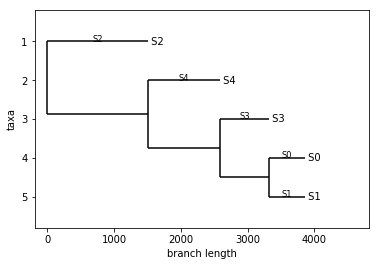

In [2]:
A="MSLTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGESSPTIATLWKIASGLEASFSAFFANDPQLLSS\
ERSFPDDLNMKIHTLFPYAADTGLEIFEITLLDHHQQMSSPHALGVIEYIHVLEGIMKVFFDEQWHELQQGEHIRFFSDQ\
PHGYAAVTEKAVFQNIVAYPRREGGSHHHHHH"

F="MILDTDYITEDGKPVIRIFKKENGEFKIEYDRTFEPYFYALLKDDSAIEEVKKITAERHGTVVTVKRVEKVQKKFLGRPV\
EVWKLYFTHPQDVPAIRDKIREHPAVIDIYEYDIPFAKRYLIDKGLVPMEGDEELKMLAFDIETLYHEGEEFAEGPILMI\
SYADEEGARVITWKNVDLPYVDVVSTEREMIKRFLRVVKEKDPDVLITYNGDNFDFAYLKKRCEKLGINFALGRDGSEPK\
IQRMGDRFAVEVKGRIHFDLYPVIRRTINLPTYTLEAVYEAVFGQPKEKVYAEEITTAWETGENLERVARYSMEDAKVTY\
ELGKEFLPMEAQLSRLIGQSLWDVSRSSTGNLVEWFLLRKAYERNELAPNKPDEKELARRRQSYEGGYVKEPERGLWENI\
VYLDFRSLYPSIIITHNVSPDTLNREGCKEYDVAPQVGHRFCKDFPGFIPSLLGDLLEERQKIKKKMKATIDPIERKLLD\
YRQRAIKILANSYYGYYGYARARWYCKECAESVTAWGREYITMTIKEIEEKYGFKVIYSDTDGFFATIPGADAETVKKKA\
MEFLKYINAKLPGALELEYEGFYKRGFFVTKKKYAVIDEEGKITTRGLEIVRRDWSEIAKETQARVLEALLKDGDVEKAV\
RIVKEVTEKLSKYEVPPEKLVIHEQITRDLKDYKATGPHVAVAKRLAARGVKIRPGTVISYIVLKGSGRIGDRAIPFDEF\
DPTKHKYDAEYYIENQVLPAVERILRAFGYRKEDLRYQKTRQVGLSAWLKPKGT"

B="MASPDEDNPGILYNGRFDFSDPNGPKCAWSGSNVELNFYGTEASVTIKSGGENWFQAIVDGNPLPPFSVNATTSTVKLVS\
GLAEGAHHLVLWKRTEASLGEVQFLGFDFGSGKLLAAPKPLERKIEFIGDSITCAYGNEGTSKEQSFTPKNENSYMSYAA\
ITARNLNASANMIAWSGIGLTMNYGGAPGPLIMDRYPYTLPYSGVRWDFSKYVPQVVVINLGTNDFSTSFADKTKFVTAY\
KNLISEVRRNYPDAHIFCCVGPMLWGTGLDLCRSYVTEVVNDCNRSGDLKVYFVEFPQQDGSTGYGEDWHPSIATHQLMA\
ERLTAEIKNKLGWLEHHHHHH"

C="MNSPVDAPKWPRQIPYIIAQEACERFSFYGMRNILTPFLMTALLLSIPEELRGAVAKDVFHSFVIGVYFFPLLGGWIADR\
FFGKYNTILWLSLIYCVGHAFLEIFEHSVQGFYTGLFLIALGSGGIKPLVSSFMGDQFDQSNKSLAQKAFDMFYFTINFG\
SFFASLSMPLLLKNFGAAVAFGIPGVLMFVATVFFWLGRKRYIHMPPEPKDPHGFLPVIRSALLTKVEGKGNIGLVLALI\
GGVSAAYALVNIPTLGIVAGLCCAMVLVMGFVGAGASLQLERARKSHPDAAVDGVRSVLRILVLFALVTPFWSLFDQKAS\
TWILQANDMVKPQWFEPAMMQALNPLLVMLLIPFNNFVLYPAIERMGVKLTALRKMGAGIAITGLSWIVVGTIQLMMDGG\
SALSIFWQILPYALLTFGEVLVSATGLEFAYSQAPKAMKGTIMSFWTLSVTVGNLWVLLANVSVKSPTVTEQIVQTGMSV\
TAFQMFFFAGFAILAAIVFALYARSYQMQDHYRQATGSENLYFQ"

D="MNSPVDAPKWPRQIPYIIASEACERFSFYGMRNILTPFLMTALLLSIPEELRGAVAKDVFHSFVIGVYFFPLLGGWIADR\
FFGKYNTILWLSLIYCVGHAFLAIFEHSVQGFYTGLFLIALGSGGIKPLVSSFMGDQFDQSNKSLAQKAFDMFYFTINFG\
SFFASLSMPLLLKNFGAAVAFGIPGVLMFVATVFFWLGRKRYIHMPPEPKDPHGFLPVIRSALLTKVEGKGNIGLVLALI\
GGVSAAYALVNIPTLGIVAGLCCAMVLVMGFVGAGASLQLERARKSHPDAAVDGVRSVLRILVLFALVTPFWSLFDQKAS\
TWILQANDMVKPQWFEPAMMQALNPLLVMLLIPFNNFVLYPAIERMGVKLTALRKMGAGIAITGLSWIVVGTIQLMMDGG\
SALSIFWQILPYALLTFGEVLVSATGLEFAYSQAPKAMKGTIMSFWTLSVTVGNLWVLLANVSVKSPTVTEQIVQTGMSV\
TAFQMFFFAGFAILAAIVFALYARSYQMQDHYRQATGSENLYFQ"


E = "MNSPVDAPKWPRQIPYIIASEACERFSFYGMRNILTPFLMTALLLSIPEELRGAVAQDVFHSFVIGVYFFPLLGGWIADR\
FFGKYNTILWLSLIYCVGHAFLAIFEHSVQGFYTGLFLIALGSGGIKPLVSSFMGDQFDQSNKSLAQKAFDMFYFTINFG\
SFFASLSMPLLLKNFGAAVAFGIPAVLMFVATVFFWLGRKRYIHMPPEPKDPHGFLPVIRSALLTKVEGKGNIGLVLALI\
GGVSAAYALVNIPTLGIVAGLCCAMVLVMGFVGAGASLQLERARKSHPDAAVDGVRSVLRILVLFALVTPFWSLFDQKAS\
TWILQANDMVKPQWFEPAMMQALNPLLVMLLIPFNNFVLYPAIERMGVKLTALRKMGAGIAITGLSWIVVGTIQLMMDGG\
SALSIFWQILPYALLTFGEVLVSATGLEFAQSQAPKAMKGTIMSFWTLSVTVGNLWVLLANVSVKSPTVTEQIVQTGMSV\
TAFQMFFFAGFAILAAIVFALYARSYQMQDHYRQATGSENLYFQ"


main(A,B,C,D,F)